In [1]:
import os
import datetime
import seaborn as sns
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, save_summary_and_results

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score

import tensorflow
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

tensorflow.config.list_physical_devices('GPU')
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:    # Restrict TensorFlow to only allocate memory on the GPU dynamically
    for gpu in gpus:
        tensorflow.config.experimental.set_memory_growth(gpu, True)
    tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')

from tensorflow.keras.models        import Sequential, Model, load_model
from tensorflow.keras.initializers  import GlorotUniform
from tensorflow.keras.layers        import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers        import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers        import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers        import concatenate, Concatenate
from tensorflow.keras.optimizers    import Adam
from tensorflow.keras.losses        import BinaryCrossentropy
from tensorflow.keras.metrics       import AUC, Precision, Recall

from tensorflow.keras.utils         import plot_model


folder_path = '/home/rl_sim/thesis_ws/src/RobotData_GRIPA320'
data_folder = '/home/rl_sim/thesis_ws/src/ML/DATA/1D_TRANSF_FTP_NotNorm'

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

#X_data = np.dstack((X_data[:, :, 2], X_data[:, :, 0], X_data[:, :, 6], X_data[:, :, 7],X_data[:, :, 8]))    # TO DECOMMENT!
print("\nSelectedInputs: ", X_data.shape)
print("SelectedInputs: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)
print("X_train shape:", X_train.shape)

IN_SHAPE = (WS_B, 5) #X_data[0].shape
TYPEm = "ANN_G"

2024-09-08 16:40:47.360872: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 16:40:47.386290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 16:40:47.784844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-08 16:40:48.086043: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more 

X_data shape: (1465, 800, 9)
y_data shape: (1465,)
X_data.[0] shape:  (800, 9)

SelectedInputs:  (1465, 800, 9)
SelectedInputs:  (800, 9)

TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800, 9)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800, 9)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800, 9)    ||  Dimensions of y_val:   (293,)
X_train shape: (879, 800, 9)


In [2]:
X_train_ = np.dstack([X_train[:, :, i] for i in range(9)])
X_val_ = np.dstack([X_val[:, :, i] for i in range(9)])
X_test_ = np.dstack([X_test[:, :, i] for i in range(9)])

print("X_train shape:", X_train_.shape)


X_train shape: (879, 800, 9)


Model: "easyModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 80, 256)        │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 40, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling1D)        │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       163,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,865 (1.67 MB)

 Trainable params: 436,865 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

X_train shape: (879, 800, 1)
Epoch 1/60


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5591 - loss: 0.7540 - val_accuracy: 0.6143 - val_loss: 0.6029
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6147 - loss: 0.5818 - val_accuracy: 0.6928 - val_loss: 0.5548
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6993 - loss: 0.5153 - val_accuracy: 0.7338 - val_loss: 0.5061
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7688 - loss: 0.4748 - val_accuracy: 0.7133 - val_loss: 0.5136
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7671 - loss: 0.4713 - val_accuracy: 0.7543 - val_loss: 0.5114
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8022 - loss: 0.4282 - val_accuracy: 0.6621 - val_loss: 0.6617
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7614 - loss: 0.4708 - val_accuracy: 0.7338 - val_loss: 0.4965
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7822 - loss: 0.4232 - val_accuracy: 0.8020 - val_loss: 0.4429
Ep

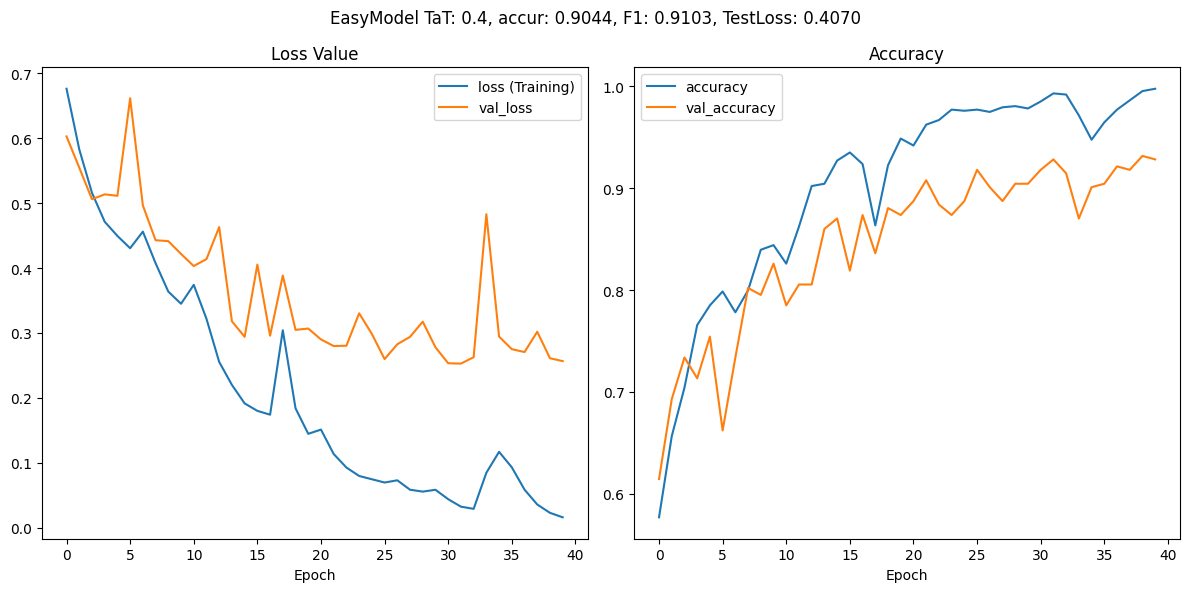

Train loss: 0.015944384038448334
Test val_loss: 0.2566186785697937
Train accuracy: 0.997724711894989
Accuracy Score: 0.9044368600682594
F1 Score: 0.9102564102564102
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       137
         1.0       0.91      0.91      0.91       156

    accuracy                           0.90       293
   macro avg       0.90      0.90      0.90       293
weighted avg       0.90      0.90      0.90       293



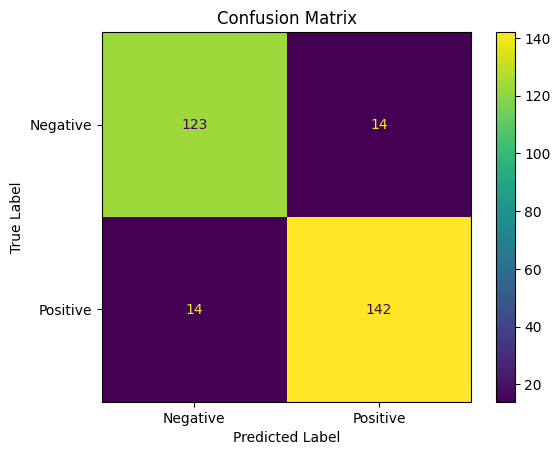

In [14]:
def build_easyModel():
    inputs = Input(shape=(800, 1), name='input_layer')
    x = Conv1D(filters=256, kernel_size=40, strides= 10, padding='same', activation='relu', name='conv1d_1')(inputs)
    x = Conv1D(filters=256, kernel_size=4, strides=2, activation='relu', padding='same', name='conv1d_2')(x)
    x = MaxPooling1D(pool_size=4, name='maxpool_1')(x)
    #x = GlobalMaxPooling1D()(x)
    x = Flatten(name='flatten')(x)
    x = Dense(64, activation='relu', name='dense_1')(x)
    outputs = Dense(1, activation='sigmoid', name='output_layer')(x)
    model = Model(inputs=inputs, outputs=outputs, name='easyModel')
    return model

model = build_easyModel()
model.summary()

X_train_ = np.dstack([X_train[:, :, 2]])
X_val_ = np.dstack([X_val[:, :, 2]])
X_test_ = np.dstack([X_test[:, :, 2]])

print("X_train shape:", X_train_.shape)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train_, y_train, epochs=60, batch_size=32, validation_data=(X_val_, y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test_, y_test)

# Predict labels for test data
y_pred = model.predict(X_test_)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)